In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from pandas.plotting import register_matplotlib_converters
from xgboost import plot_importance, plot_tree

In [123]:
# lib configuration
register_matplotlib_converters()
plt.rcParams["figure.figsize"] = (15,8)

In [124]:
# https://www.kaggle.com/mczielinski/bitcoin-historical-data
DATASET_PATH = "data/bitcoin-historical.csv"

In [125]:
df = pd.read_csv(DATASET_PATH)

In [126]:
old_size = df.size

In [127]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data transforamtion

Dataset contains a lot of empty rows, we should wipe out that unnecessary data. Also, we should map unix timestamps to normal datetime objects

In [128]:
df = df.dropna(thresh=3)

In [129]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [130]:
# amount of dropped rows (huge)
old_size - df.size

9855024

In [131]:
# copnver unit timestamp to datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [132]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


Text(0, 0.5, 'Cost of Bition in USD')

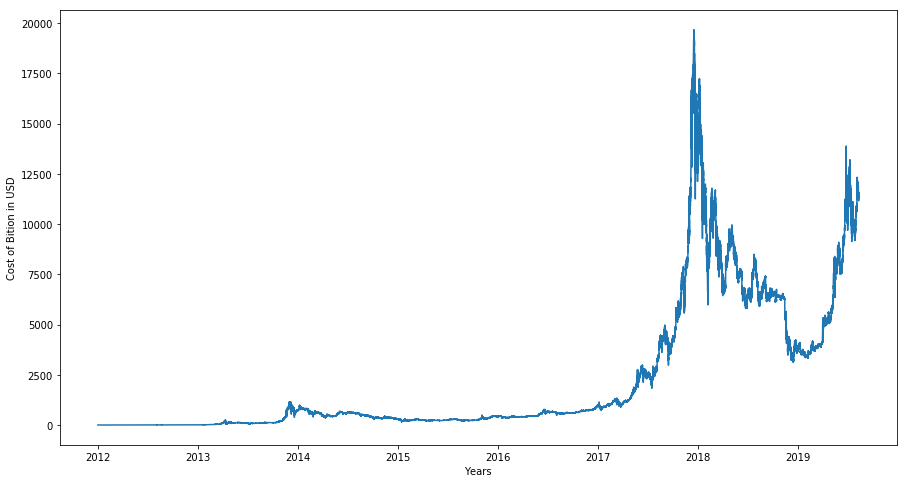

In [133]:
plt.plot(df['Timestamp'], df['High'])
plt.xlabel('Years')
plt.ylabel('Cost of Bition in USD')

As we see, bitcoin data is pretty unpreditable. No model could predict all of those spikes, due to this fact I will train models on small section of dataset.

In [134]:
split_date = '2018-01-01'
df_cut = df.loc[df['Timestamp'] >= split_date].copy()

Text(0.5, 1.0, 'Bitcoin 2018-01-01 to 2019-08-12')

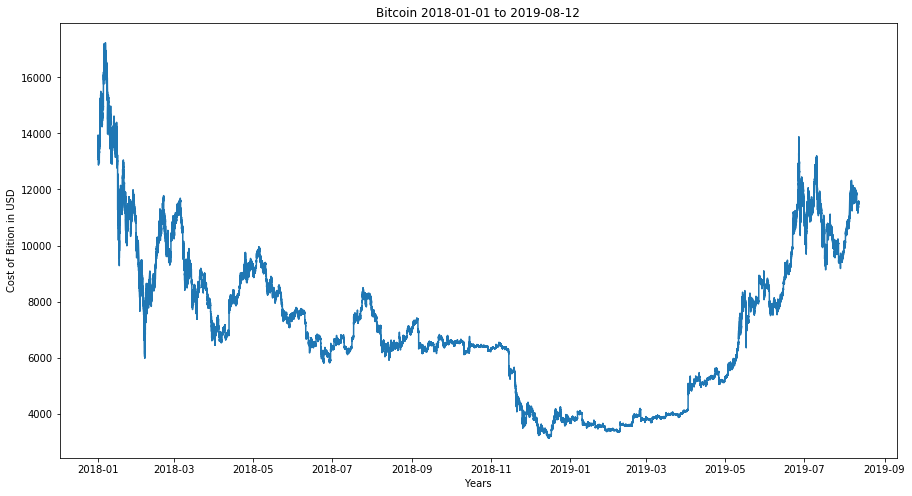

In [135]:
plt.plot(df_cut['Timestamp'], df_cut['High'])
plt.xlabel('Years')
plt.ylabel('Cost of Bition in USD')
plt.title("Bitcoin 2018-01-01 to 2019-08-12")

In [171]:
train_split = '2019-05-15'
bitcoin_train = df_cut.loc[df_cut['Timestamp'] <= train_split].copy()
bitcoin_test = df_cut.loc[df_cut['Timestamp'] > train_split].copy()

Text(0.5, 1.0, 'Splitted dateset')

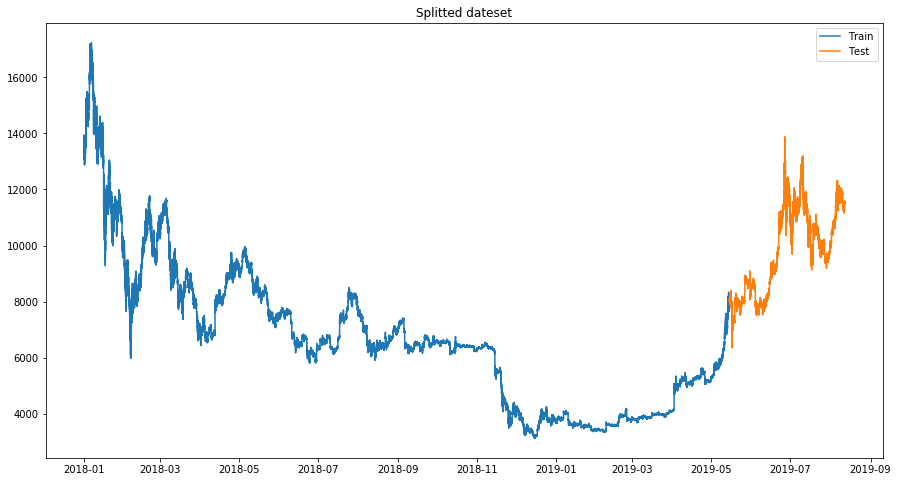

In [172]:
plt.plot(bitcoin_train['Timestamp'], bitcoin_train['High'], label='Train')
plt.plot(bitcoin_test['Timestamp'], bitcoin_test['High'], label='Test')
plt.legend(loc='best')
plt.title("Splitted dateset")

In [173]:
# borrow (with some tweaks) those functions from previous notebook

def create_features_dep(df, x_label='Timestamp', y_label='High'):
    return df[x_label].as_matrix().reshape((-1,1)), df[y_label].as_matrix()


def create_features(df, x_label='Timestamp', y_label='High'):
    # removed year feature, as we are working on 1.5 year sample
    df['hour'] = df[x_label].dt.hour
    df['quarter'] = df[x_label].dt.quarter
    df['month'] = df[x_label].dt.month
    df['dayofyear'] = df[x_label].dt.dayofyear
    df['dayofmonth'] = df[x_label].dt.day
    df['weekofyear'] = df[x_label].dt.weekofyear
    
    X = df[['hour','dayofyear','quarter','month', 'weekofyear', 'dayofmonth']]
    y = df[y_label]

    return X, y

In [174]:
X_train, y_train = create_features(bitcoin_train)
X_test, y_test = create_features(bitcoin_test)

In [180]:
X_train

,hour,dayofyear,quarter,month,weekofyear,dayofmonth
3150976,0,1,1,1,1,1
3150977,0,1,1,1,1,1
3150978,0,1,1,1,1,1
3150979,0,1,1,1,1,1
3150980,0,1,1,1,1,1
3150981,0,1,1,1,1,1
3150982,0,1,1,1,1,1
3150983,0,1,1,1,1,1
3150984,0,1,1,1,1,1
3150985,0,1,1,1,1,1


### Predictions - using XGBoost (XGBRegressor)

In [175]:
reg = xgb.XGBRegressor(n_estimators=1500, booster='dart', n_jobs=8, importance_type='weight')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # too much logs 

[16:10:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='weight', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=8, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

Again let's check importance of each feature

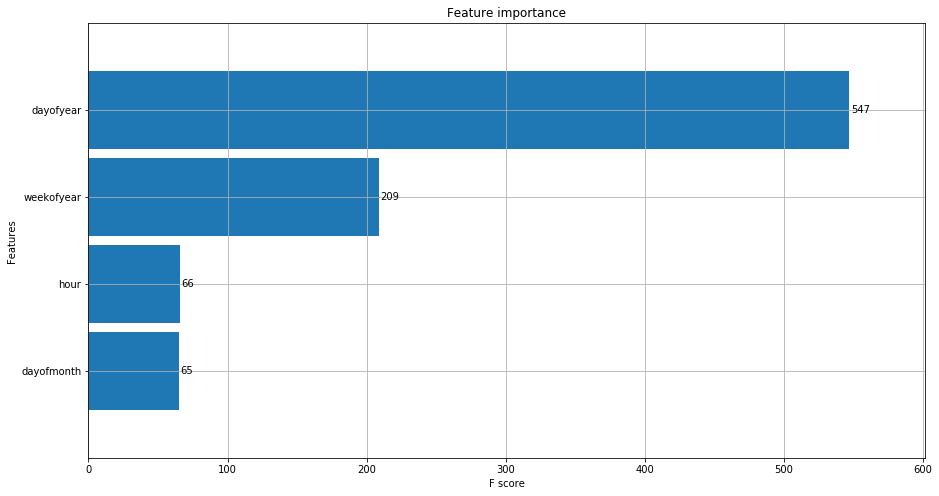

In [176]:
plot_importance(reg, height=0.9)

As everyone should predict (lol), day of year is the most significant feature in our dataset

In [177]:
bitcoin_test['hight_prediction'] = reg.predict(X_test)

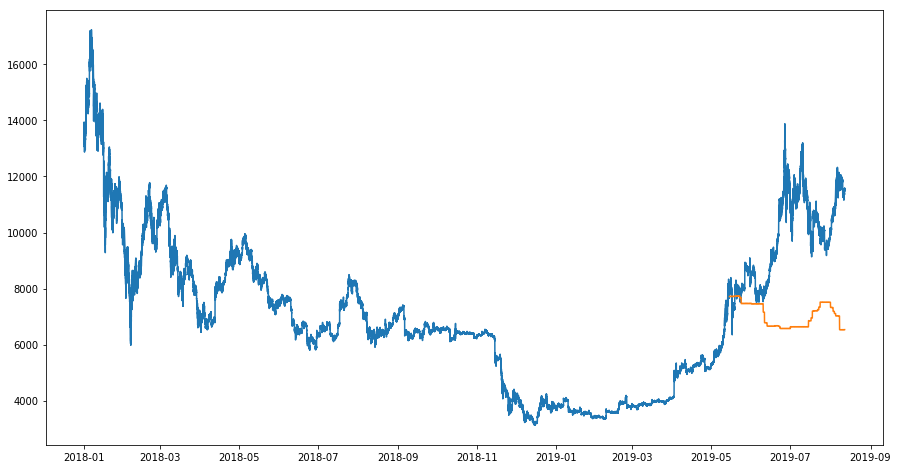

In [178]:
# plot predictions
plt.plot(df_cut['Timestamp'], df_cut['High'])
plt.plot(bitcoin_test['Timestamp'], bitcoin_test['hight_prediction'])

### Predictions - using ETS

In [179]:
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [ ]:
y_hat_avg = bitcoin_test.copy()
fit1 = ExponentialSmoothing(np.asarray(bitcoin_train['High']), seasonal_periods=7, trend='add', seasonal='mul').fit() 

# fit1 = ExponentialSmoothing(np.asarray(co_train['avg_measurement']) ,seasonal_periods=4 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(bitcoin_test))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(bitcoin_train['Timestamp'], bitcoin_train['High'], label='Train')
plt.plot(bitcoin_test['Timestamp'], bitcoin_test['High'], label='Test')
plt.plot(bitcoin_test['Timestamp'], y_hat_avg['Holt_Winter'], '-', label='Holt_Winter')
plt.legend(loc='best')
plt.show()